### Libraries and used functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import datetime as dt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import requests
import plotly.express as px
import plotly.graph_objects as go

from IPython.display import HTML

from scipy.stats import f_oneway
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu

%matplotlib inline
# from pydantic_settings import BaseSettings
#from ydata_profiling import ProfileReport

import sys
import os
sys.path.append('../utils/')
#sys.path.append('..\\utils\\')

from functions import get_zone_info
from functions import haversine_distance as hsd
from functions import main_concurrent

In [3]:
def generate_custom_colorscale(n_steps, colormap, dark_start=True):
    """
    Generate a custom green color scale with n_steps.
    
    Args:
    - n_steps: Number of steps in the color scale.
    - dark_start: If True, start with a darker green; otherwise, start lighter.
    
    Returns:
    - A list of color strings in RGB format.
    """
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0.3 if dark_start else 0, 1, n_steps)]  # Start from 0.3 to avoid too light colors
    # Convert colors to RGB format for Plotly
    plotly_colors = ["rgb({},{},{})".format(int(r*255), int(g*255), int(b*255)) for r, g, b, _ in colors]
    return plotly_colors

## Data Cleaning and Preprocessing. Exploratory and Confirmatory Data Analysis

### 1. Data Cleaning and Processing.

In [4]:
# Initialize ShareNow and GreenMobility datasets
gm_original = pd.read_csv('../data/raw/GM_preparedData.csv')
sn_original = pd.read_excel('../data/raw/DriveNow/DTU - data til case_LTMZones1.xlsx')

# Initialize Donkey Republic datasets
dr_path = '../data/raw/DonkeyRepublic/'
hubs = pd.read_excel(dr_path + 'Hubs_2019-4-2_1201.xlsx', parse_dates=['created_at'])
rentals = pd.read_excel(dr_path + 'Rentals_2019-4-2_1456.xlsx', parse_dates=['created_at', 'finished_at'])

#   ----------------------------------------------------------------------------
#   SHARENOW PART
#   ----------------------------------------------------------------------------

# Rename ShareNow columns
dict_sn_renamecols =    {'TurID':'TripID',
                        'BilID':'CarID',
                        'PersonID':'UserID',
                        'Latitude (Start)':'LatitudeStart',
                        'Longitude (Start)':'LongitudeStart',
                        'Latitude (Slut)': "LatitudeEnd", 
                        'Longitude (Slut)':'LongitudeEnd',
                        'Reservationstidspunkt': 'ReservationTime',
                        'Start tidspunkt': 'StartTime',
                        'Slut tidspunkt': 'EndTime',
                        'Alder': 'Age',
                        'Køn': 'Gender',
                        'Batteristatus (start)': 'BatteryStart',
                        'Batteristatus (slut)':'BatteryEnd',
                        'Km kørt': 'KmDriven'}

sn_processing = sn_original.rename(columns=dict_sn_renamecols)

# Check the data types of the dimensions
print(sn_processing.info())

# Convert BatteryStart and BatteryEnd to Integer type
sn_processing['BatteryStart'] = pd.to_numeric(sn_processing['BatteryStart'],errors='coerce')
sn_processing['BatteryEnd'] = pd.to_numeric(sn_processing['BatteryEnd'],errors='coerce')

# Convert location coordinates to floating type
coordinates = [
    'LatitudeEnd',
    'LatitudeStart',
    'LongitudeEnd',
    'LongitudeStart'
]

for col in coordinates:
    # sn_processing[col] = sn_processing[col].apply(lambda x: x.replace(',','.'))
    sn_processing[col] = pd.to_numeric(sn_processing[col],errors='coerce')

# Auxiliary columns
sn_processing['TripDurationHours'] = (sn_processing['EndTime'] - sn_processing['StartTime']).dt.total_seconds()/3600
sn_processing['TripDurationMinutes'] = sn_processing['TripDurationHours']*60  #   trip duration in min
sn_processing['AvgSpeed'] = sn_processing['KmDriven']/sn_processing['TripDurationHours'] #   avg speed
sn_processing['Month'] = sn_processing['StartTime'].dt.strftime("%B").astype('category')  #   month
sn_processing['Weekday'] = sn_processing['StartTime'].dt.day_name().astype('category')    #   day of the week
sn_processing['StartHour'] = sn_processing['StartTime'].dt.hour.astype('category')    #   hour of the day
sn_processing['Date'] = sn_processing['StartTime'].dt.date  #   date

sn_processing['HaversineDistance'] = hsd(sn_processing['LatitudeStart'], sn_processing['LongitudeStart'],sn_processing['LatitudeEnd'], sn_processing['LongitudeEnd'])

# Custom cut for age interval
dfbrackets = pd.DataFrame({
    'ranges': [range(18, 30), range(30, 40), range(40, 50), range(50, 60), range(60, 91)],
    'brackets': ['18-29', '30-39', '40-49', '50-59', '60-90']
}).explode('ranges')

dfbrackets['ranges'] = dfbrackets['ranges'].astype(int)

def get_bracket(age):
    bracket = dfbrackets.loc[dfbrackets['ranges'] == age, 'brackets']
    return bracket.iloc[0] if not bracket.empty else None

sn_processing['AgeBracket'] = sn_processing['Age'].apply(get_bracket)

#   ----------------------------------------------------------------------------
#   GREENMOBILITY PART
#   ----------------------------------------------------------------------------

# Rename GreenMobility columns
dict_gm_renamecols = {'id':'TripID',
                        'vehicleId':'CarID',
                        'id2':'UserID',
                        'startPositionLat':'LatitudeStart',
                        'startPositionLng':'LongitudeStart',
                        'endPositionLat':'LatitudeEnd',
                        'endPositionLng':'LongitudeEnd',
                        'tripStart':'StartTime',
                        'tripEnd':'EndTime',
                        'birthday':'Age',
                        'key':'Gender',
                        'DriveLength':'KmDriven'
                      }

# List the columns to be kept for GreenMobility
gmkeepcols_list = ['TripID','CarID',
                   'UserID','LatitudeStart',
                   'LongitudeStart','LatitudeEnd',
                   'LongitudeEnd','StartTime',
                   'EndTime','Age','Gender','KmDriven',
                   'FromZoneID','ToZoneID']

gm_processing = gm_original.rename(columns=dict_gm_renamecols)
gm_processing = gm_processing[gmkeepcols_list]

# Convert StartTime and EndTime to Datetime
gm_processing['StartTime'] = pd.to_datetime(gm_processing['StartTime'], errors='coerce', format='%d%b%y:%H:%M:%S')
gm_processing['EndTime'] = pd.to_datetime(gm_processing['EndTime'], errors='coerce' , format='%d%b%y:%H:%M:%S')

gm_processing['TripDurationHours'] = (gm_processing['EndTime'] - gm_processing['StartTime']).dt.total_seconds()/3600
gm_processing['TripDurationMinutes'] = gm_processing['TripDurationHours']*60  #   trip duration in min
gm_processing['AvgSpeed'] = gm_processing['KmDriven']/gm_processing['TripDurationHours'] #   avg speed
gm_processing['Month'] = gm_processing['StartTime'].dt.strftime("%B").astype('category')  #   month
gm_processing['Weekday'] = gm_processing['StartTime'].dt.day_name().astype('category')    #   day of the week
gm_processing['StartHour'] = gm_processing['StartTime'].dt.hour.astype('category')    #   hour of the day
gm_processing['Date'] = gm_processing['StartTime'].dt.date  #   date
gm_processing['AgeBracket'] = gm_processing['Age'].apply(get_bracket)   #   age bracket

gm_processing['HaversineDistance'] = hsd(gm_processing['LatitudeStart'], gm_processing['LongitudeStart'],gm_processing['LatitudeEnd'], gm_processing['LongitudeEnd'])
gm_processing['UserID'] = gm_processing['UserID'].astype(int)

#   ----------------------------------------------------------------------------
#   DONKEY REPUBLIC PART
#   ----------------------------------------------------------------------------

renamecols = {'user_id':'UserID','created_at':'StartTime','finished_at':'EndTime'}

# replace non-ascii characters in hubs names
hubs['name'] = hubs['name'].str.replace('Ã¦', 'æ', regex=True)  # replace Ã¦ with æ in hubs names
hubs['name'] = hubs['name'].str.replace('Ã¸', 'ø', regex=True)  # replace Ã¸Ã˜ with ø, Ø in hubs names
hubs['name'] = hubs['name'].str.replace('Ã¥', 'å', regex=True)  # replace Ã¥ with å in hubs names
hubs['name'] = hubs['name'].str.replace('Ã…', 'Å', regex=True)  # replace Ã… with Å in hubs names
hubs['name'] = hubs['name'].str.replace('Ã˜', 'Ø', regex=True)  
hubs['name'] = hubs['name'].str.replace('Ã©', 'é', regex=True)  # replace Ã© with é in hubs names
hubs['name'] = hubs['name'].str.replace('Ã¼', 'ü', regex=True)  # replace Ã¼ with ü in hubs names
hubs['name'] = hubs['name'].str.replace('Ã¶', 'ö', regex=True)  # replace Ã¶ with ö in hubs names

# remove entire substring if it is in between [] like [N], [G]...
hubs['name'] = hubs['name'].str.replace('\[[^\]]*\]', '', regex=True)


rentals.replace([np.inf, -np.inf], np.nan, inplace=True)    #   replace infinite values with NaN
rentals['dropoff_hub_id'] = rentals['dropoff_hub_id'].astype('Int64')

# Get the Start and End coordinates for each rental from hubs file
dr_processing = rentals.merge(hubs[['id', 'latitude', 'longitude','name']], left_on='pickup_hub_id', right_on='id', how='left') #  merge with hubs to get start coordinates
dr_processing = dr_processing.rename(columns={'latitude':'LatitudeStart', 'longitude':'LongitudeStart', 'name':'StartHubName'}) # rename columns

dr_processing = dr_processing.merge(hubs[['id', 'latitude', 'longitude', 'name']], left_on='dropoff_hub_id', right_on='id', how='left') #  merge with hubs to get end coordinates
dr_processing = dr_processing.rename(columns={'latitude': 'LatitudeEnd', 'longitude': 'LongitudeEnd', 'name': 'EndHubName'})    # rename columns
dr_processing = dr_processing.drop(['id_x', 'id_y'], axis=1)

dr_processing.rename(columns=renamecols, inplace=True)

dr_processing['StartTime'] = pd.to_datetime(dr_processing['StartTime'], errors='coerce', format='mixed')
dr_processing['EndTime'] = pd.to_datetime(dr_processing['EndTime'], errors='coerce' , format='mixed')

dr_processing['TripDurationHours'] = (dr_processing['EndTime'] - dr_processing['StartTime']).dt.total_seconds()/3600
dr_processing['TripDurationMinutes'] = dr_processing['TripDurationHours']*60  #   trip duration in min

dr_processing['Month'] = dr_processing['StartTime'].dt.strftime("%B").astype('category')  #   month
dr_processing['Weekday'] = dr_processing['StartTime'].dt.day_name().astype('category')    #   day of the week
dr_processing['StartHour'] = dr_processing['StartTime'].dt.hour.astype('category')    #   hour of the day
dr_processing['Date'] = dr_processing['StartTime'].dt.date  #   date

dr_processing['HaversineDistance'] = hsd(gm_processing['LatitudeStart'], gm_processing['LongitudeStart'],gm_processing['LatitudeEnd'], gm_processing['LongitudeEnd'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366420 entries, 0 to 366419
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   TripID           366420 non-null  int64         
 1   CarID            366420 non-null  object        
 2   UserID           366420 non-null  int64         
 3   LatitudeStart    366420 non-null  object        
 4   LongitudeStart   366420 non-null  object        
 5   LatitudeEnd      366420 non-null  object        
 6   LongitudeEnd     366420 non-null  object        
 7   ReservationTime  366420 non-null  datetime64[ns]
 8   StartTime        366420 non-null  datetime64[ns]
 9   EndTime          366420 non-null  datetime64[ns]
 10  Age              366420 non-null  int64         
 11  Gender           366420 non-null  object        
 12  BatteryStart     366420 non-null  object        
 13  BatteryEnd       366420 non-null  object        
 14  KmDriven         366

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

### 1.1 Data cleaning and processing : SHARE NOW

In [ ]:
# Summary statics on numerical variables for SN
describecols = ['Age','BatteryStart','BatteryEnd','KmDriven','TripDurationHours','TripDurationMinutes','AvgSpeed']
sn_summary = sn_processing[describecols].describe().T

sn_summary.rename(columns={'std':'st deviation','50%':'median'}, inplace = True)
sn_summary.drop(columns='count', inplace=True)

display(HTML('<p style="font-size:20px; font-family:Consolas;">Descriptive statistics for Share Now</p>'))
sn_summary.style.format("{:.2f}")

,mean,st deviation,min,25%,median,75%,max
Age,33.13,9.61,18.00,26.00,31.00,39.00,89.00
BatteryStart,59.66,23.70,-1.00,41.00,59.00,78.00,100.00
BatteryEnd,50.47,24.30,-1.00,32.00,50.00,69.00,100.00
KmDriven,7.83,98.39,-19183.00,4.00,6.00,10.00,17771.00
TripDurationHours,0.58,1.09,-0.59,0.29,0.41,0.57,152.69
TripDurationMinutes,34.83,65.41,-35.32,17.23,24.38,34.10,9161.22
AvgSpeed,15.86,117.64,-25250.42,10.13,14.36,19.78,38820.15


##### Dropping unfeasible records for KmDriven, TripDurationMinutes, and Battery Levels

In [ ]:
# 1. Drop records with negative KmDriven and those exceeding 350km
sn_processing = sn_processing[(sn_processing['KmDriven']>0)&(sn_processing['KmDriven']<350)]

# 2. Drop records with negative trip duration
sn_processing = sn_processing[sn_processing['TripDurationMinutes']>=0]

# 3. Drop records where BatteryStart is greater than BatteryEnd and negative values
sn_processing = sn_processing[(sn_processing['BatteryStart']>=sn_processing['BatteryEnd']) & (sn_processing['BatteryStart']>=0) & (sn_processing['BatteryEnd']>0)]

# 4. Drop records where AvgSpeed exceeds 100 km/h
sn_processing = sn_processing[sn_processing['AvgSpeed']<100]

# 5. Drop records where TripDurationHours is greater than 5
sn_processing = sn_processing[sn_processing['TripDurationHours']<6]

In [ ]:
sn_processing[sn_processing['KmDriven']>3][describecols].describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
Age,274851.00,33.09,9.50,18.00,26.00,31.00,39.00,89.00
BatteryStart,274851.00,60.73,22.89,6.00,43.00,60.00,79.00,100.00
BatteryEnd,274851.00,49.68,23.80,1.00,31.00,49.00,68.00,100.00
KmDriven,274851.00,9.78,8.69,4.00,5.00,7.00,11.00,236.00
TripDurationHours,274851.00,0.60,0.57,0.07,0.35,0.46,0.62,6.00
TripDurationMinutes,274851.00,35.93,34.39,4.38,20.95,27.55,37.18,359.98
AvgSpeed,274851.00,18.07,8.88,0.68,12.25,16.20,21.65,98.96


In [ ]:
# Check 85% quantile on TripDurationMinutes
sn_processing[(sn_processing['TripDurationMinutes']<sn_processing['TripDurationMinutes'].quantile(0.85))][describecols].describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
Age,299755.00,32.86,9.47,18.00,26.00,30.00,39.00,89.00
BatteryStart,299755.00,59.37,22.94,3.00,41.00,58.00,77.00,100.00
BatteryEnd,299755.00,51.69,23.72,1.00,33.00,51.00,70.00,100.00
KmDriven,299755.00,6.36,4.45,1.00,3.00,5.00,8.00,50.00
TripDurationHours,299755.00,0.38,0.14,0.02,0.28,0.37,0.48,0.69
TripDurationMinutes,299755.00,22.86,8.53,1.27,16.50,22.47,29.03,41.63
AvgSpeed,299755.00,16.58,8.70,1.44,10.85,14.85,20.17,98.96


#### Population insights

We can see that most of the SN trips are made by people younger than 30 years, however, they tend to drive shorter distances, while doing it faster on average.

In [ ]:
n_steps = 5  # Define the number of steps you want in your color scale
custom_blue_scale = generate_custom_colorscale(n_steps, 'Blues', dark_start=True)

agg_df = sn_processing[sn_processing['KmDriven']>=3].groupby('AgeBracket')['KmDriven'].agg(['mean','count']).reset_index()
fig = px.bar(agg_df, x='AgeBracket', y='count', color='mean',
             color_continuous_scale=custom_blue_scale,
             labels={'mean': 'Km', 'count': 'Number of trips', 'AgeBracket':'Age group'})

fig.update_layout(width=500,height=600, template=None, font=dict(family='Aptos',size=18))
fig.update_traces()
# fig.update_yaxes(showgrid=False)
fig.update_xaxes(showgrid=False)
fig.show()


In [ ]:
spped = sn_processing[sn_processing['KmDriven']>=3].groupby('AgeBracket')['AvgSpeed'].agg(['mean','count']).reset_index()
fig = px.bar(spped, x='AgeBracket', y='count', color='mean',
             color_continuous_scale=custom_blue_scale,
             labels={'mean': 'Km/h', 'count': 'Number of trips', 'AgeBracket':'Age group'})

fig.update_layout(width=500,height=600, template=None, font=dict(family='Aptos',size=18))
fig.update_traces()
# fig.update_yaxes(showgrid=False)
fig.update_xaxes(showgrid=False)
fig.show()

#### Check data distributions: KmDriven, TripDurationMinutes, AvgSpeed
Cuts: KmDriven above $3$ km, TripDurationMinutes -  $85\%$

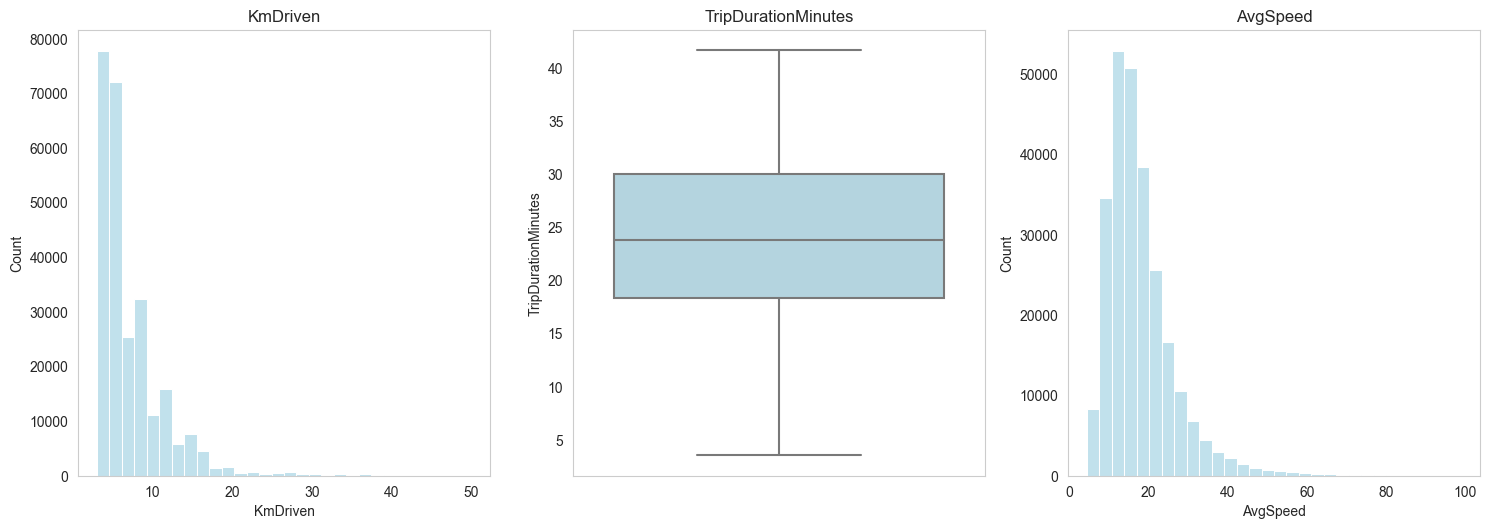

In [ ]:
columns = ['KmDriven', 'TripDurationMinutes', 'AvgSpeed']

# Set the figure size
plt.figure(figsize=(15, 10))

# Create subplots for histograms
for i, column in enumerate(columns):
    plt.subplot(2, 3, i+1)
    if column == 'TripDurationMinutes':
        sns.boxplot(data=sn_processing[(sn_processing['KmDriven']>=3)&(sn_processing['TripDurationMinutes']<sn_processing['TripDurationMinutes'].quantile(0.85))], y=column, color='lightblue')
    else:
        sns.histplot(data=sn_processing[(sn_processing['KmDriven']>=3)&(sn_processing['TripDurationMinutes']<sn_processing['TripDurationMinutes'].quantile(0.85))], x=column, bins=30,color='lightblue')
    # sns.color_palette('rocket_r')
    sns.set_style('whitegrid')
    plt.grid(False)
    plt.title(column)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Display average daily demand per hour
sn_processing['Date'] = sn_processing['StartTime'].dt.date
days = sn_processing.groupby(['Date','StartHour']).agg({'TripID':'count'}).reset_index()
dfplot = days.groupby('StartHour').agg({'TripID':'mean'},).reset_index().rename(columns={'TripID':'AvgDemand'})

In [ ]:
r = dfplot['AvgDemand'].tolist()
theta = np.arange(0,360,15)
width = [15]*24

ticktexts = [str(i)+":00" if i % 6 == 0 else '' for i in np.arange(24)]
custom_blue_scale = generate_custom_colorscale(24,'Blues',dark_start=True)

fig = go.Figure(go.Barpolar(
    r=r,
    theta=[i-7.5 for i in theta],
    width=width,
    marker_color=dfplot['AvgDemand'],
    marker_colorscale=custom_blue_scale,
    marker_line_color="white",
    marker_line_width=2,
    opacity=0.9
))

fig.update_layout(
    template=None,
    polar=dict(
        hole=0.4,
        bgcolor='rgb(223, 223,223)',
        radialaxis=dict(
            showticklabels=False,
            ticks='',
            linewidth=2,
            linecolor='white',
            showgrid=False,
        ),
        angularaxis=dict(
            tickvals=[i for i in theta],
            ticktext=ticktexts,
            showline=True,
            direction='clockwise',
            period=24,
            linecolor='white',
            gridcolor='white',
            showticklabels=True,
            ticks=''
        )
    )
)

fig.show()

In [ ]:
agg_trips_km = sn_processing[(sn_processing['KmDriven']>=3)&(sn_processing['KmDriven']<40)]\
    .groupby('Date')[['TripID','KmDriven']].agg({'TripID':'count','KmDriven':'sum'}).reset_index()
agg_trips_km['Weekday'] = pd.to_datetime(agg_trips_km['Date']).dt.day_name()
daily_trip_km = agg_trips_km.groupby('Weekday').agg({'TripID':'mean','KmDriven':'mean'}).reset_index()
daily_trip_km['KmDriven'] = np.round(daily_trip_km['KmDriven']/daily_trip_km['TripID'],decimals=2)
daily_trip_km['TripID'] = np.round(daily_trip_km['TripID'],decimals=0).astype(int)
daily_trip_km.rename(columns={'TripID':'AvgDemand','KmDriven':'AvgDistance'},inplace=True)

orderlist = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = px.bar(daily_trip_km, x='Weekday', y='AvgDemand',category_orders={'Weekday':orderlist},color='AvgDistance',
             color_continuous_scale=custom_blue_scale,
             labels={'AvgDistance': 'Km', 'AvgDemand': 'Number of trips'})

fig.update_layout(width=700,height=600, template=None, font=dict(family='Aptos',size=20))
fig.update_traces()
fig.update_yaxes(showgrid=False)
fig.update_xaxes(
    ticktext=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    tickvals=[0, 1, 2, 3, 4, 5, 6], showgrid=False, title=None
)

fig.show()

In [ ]:
# Perform the Pearson correlation test
monday = sn_processing[sn_processing['Weekday'] == 'Monday']['KmDriven']
sunday = sn_processing[sn_processing['Weekday'] == 'Sunday']['KmDriven']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(monday, sunday, alternative='two-sided')

# Print the test results
print("Mann-Whitney U statistic:", statistic)
print("p-value:", p_value)


Mann-Whitney U statistic: 1030388996.0
p-value: 3.077489241116825e-05


In [ ]:
sn_processing.groupby('AgeBracket')['UserID'].unique().apply(len).reset_index().rename(columns={'UserID':'Number of users'})

,AgeBracket,Number of users
0,18-29,10635
1,30-39,7758
2,40-49,4411
3,50-59,1886
4,60-90,443


In [ ]:
# Extract the average speed for each age group
age_group_18_29 = sn_processing[sn_processing['AgeBracket'] == '18-29']['AvgSpeed']
age_group_30_39 = sn_processing[sn_processing['AgeBracket'] == '30-39']['AvgSpeed']
age_group_40_49 = sn_processing[sn_processing['AgeBracket'] == '40-49']['AvgSpeed']
age_group_50_59 = sn_processing[sn_processing['AgeBracket'] == '50-59']['AvgSpeed']
age_group_60_90 = sn_processing[sn_processing['AgeBracket'] == '60-90']['AvgSpeed']

# Perform one-way ANOVA test
f_statistic, p_value = f_oneway(age_group_18_29, age_group_30_39, age_group_40_49, age_group_50_59, age_group_60_90)

# Check the p-value
if p_value < 0.05:
    print("There is a statistically significant difference between the mean of average speed across age groups.")
else:
    print("There is no statistically significant difference between the mean of average speed across age groups.")


There is a statistically significant difference between the mean of average speed across age groups.


In [ ]:
# Extract the 'Age' and 'AvgSpeed' columns from the DataFrame
age = sn_processing['Age']
avg_speed = sn_processing['AvgSpeed']

# Perform the Pearson correlation test
correlation, p_value = pearsonr(age, avg_speed)

# Print the correlation coefficient and p-value
print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)


Pearson correlation coefficient: -0.06216925649391497
p-value: 5.858472794464589e-299


In [ ]:
sn_processing_groupusers = sn_processing.groupby('UserID')\
    .agg({'TripID':'count','TripDurationMinutes':'mean','KmDriven':'mean'})\
    .reset_index().rename(columns={'TripID':'Number of trips','TripDurationMinutes':'Time (min)','KmDriven':'Trip (km)'})\
    .sort_values('Number of trips',ascending=False)

In [ ]:
sn_processing_groupusers\
    .head(15)\
    .style.format({'Time (min)':"{:.2f}",'Trip (km)':"{:.2f}"})

,UserID,Number of trips,Time (min),Trip (km)
10731,35595,788,18.02,4.38
16190,45868,785,31.65,7.28
13609,41516,670,22.10,3.65
2625,10152,641,31.57,7.09
841,2889,504,28.18,6.09
10810,35768,456,23.95,4.43
5697,22484,420,28.21,5.31
16996,46971,395,19.71,5.27
13835,41919,393,24.53,6.74
154,605,386,41.29,7.69


In [ ]:
sn_processing_groupusers\
    .tail(15)\
    .style.format({'Time (min)':"{:.2f}",'Trip (km)':"{:.2f}"})

,UserID,Number of trips,Time (min),Trip (km)
19995,51152,1,34.32,6.00
19994,51150,1,36.68,10.00
13459,41202,1,20.37,2.00
19989,51144,1,101.10,35.00
19971,51112,1,22.65,3.00
13462,41205,1,43.63,16.00
19986,51139,1,58.42,16.00
13463,41206,1,43.98,17.00
19984,51135,1,29.27,7.00
8295,28987,1,27.18,5.00


In [ ]:
sn_processing_groupusers.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
UserID,25133.00,35871.55,16358.94,2.00,23863.00,39541.00,49551.00,59197.00
Number of trips,25133.00,14.03,29.84,1.00,2.00,5.00,13.00,788.00
AvgTripDuration (min),25133.00,38.75,31.99,2.92,23.58,29.83,40.61,359.37
AvgTripDistance (km),25133.00,9.93,8.61,1.00,5.39,7.50,11.33,236.00


### 1.2 GREEN MOBILITY: Data cleaning and processing

In [ ]:
describecols = ['Age','KmDriven','TripDurationHours','TripDurationMinutes','AvgSpeed']
gm_processing.replace([np.inf, -np.inf], np.nan, inplace=True)
gm_processing[describecols].describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
Age,110444.00,31.43,11.88,0.00,22.00,28.00,38.00,93.00
KmDriven,169126.00,14.23,16.22,0.54,3.19,6.98,19.05,102.00
TripDurationHours,110444.00,0.84,8.41,-0.00,0.25,0.42,0.65,2210.30
TripDurationMinutes,110444.00,50.40,504.73,-0.03,15.20,25.32,39.27,132617.73
AvgSpeed,110434.00,14.32,31.65,-4870.51,6.66,11.88,18.47,7076.26


In [ ]:
gm_processing = gm_processing[gm_processing['Age']>0]
gm_processing = gm_processing.dropna(subset=['Age', 'KmDriven', 'TripDurationMinutes', 'AvgSpeed'])
gm_processing = gm_processing[gm_processing['AvgSpeed']<100]
gm_processing = gm_processing[gm_processing['KmDriven']>3]
gm_processing[describecols].describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
Age,70520.00,31.86,11.68,18.00,22.00,28.00,39.00,93.00
KmDriven,70520.00,7.15,3.76,3.00,4.35,6.12,8.78,38.20
TripDurationHours,70520.00,0.80,9.60,0.04,0.33,0.48,0.68,2210.30
TripDurationMinutes,70520.00,47.73,575.75,2.58,19.65,28.77,41.00,132617.73
AvgSpeed,70520.00,15.51,8.71,0.00,9.43,14.05,19.96,88.99


In [ ]:
# Drop missing values in the dataset gm_processing
gm_processing = gm_processing.dropna(subset=['Age', 'KmDriven', 'TripDurationMinutes', 'AvgSpeed'])
gm_processing = gm_processing[(gm_processing['KmDriven']>0)]
gm_processing = gm_processing[gm_processing['TripDurationMinutes']>3]
gm_processing = gm_processing[gm_processing['Age']>0]
gm_processing = gm_processing[gm_processing['AvgSpeed']<100]
gm_processing = gm_processing[gm_processing['KmDriven']>3]
gm_processing = gm_processing[gm_processing['TripDurationMinutes']<gm_processing['TripDurationMinutes'].quantile(0.90)]

In [ ]:
gm_processing['KmDriven']=np.round(gm_processing['KmDriven']).astype(int)
gm_processing[describecols].describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
Age,63463.00,31.76,11.63,18.00,22.00,28.00,38.00,93.00
KmDriven,63463.00,6.98,3.64,3.00,4.00,6.00,9.00,33.00
TripDurationHours,63463.00,0.47,0.20,0.05,0.31,0.45,0.61,0.96
TripDurationMinutes,63463.00,28.23,11.94,3.13,18.80,26.85,36.63,57.88
AvgSpeed,63463.00,16.57,8.39,3.12,10.53,14.95,20.74,88.99


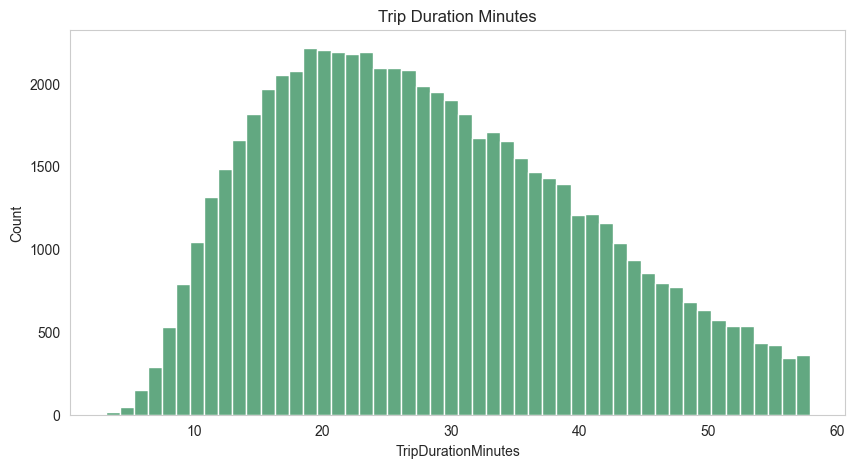

In [ ]:
# plot gm_processing['TripDurationHours'] histogram using seaborn
plt.figure(figsize=(10, 5))
sns.histplot(data=gm_processing, x='TripDurationMinutes', bins=50, color='seagreen')
sns.set_style('whitegrid')
plt.grid(False)
plt.title('Trip Duration Minutes')
plt.show()

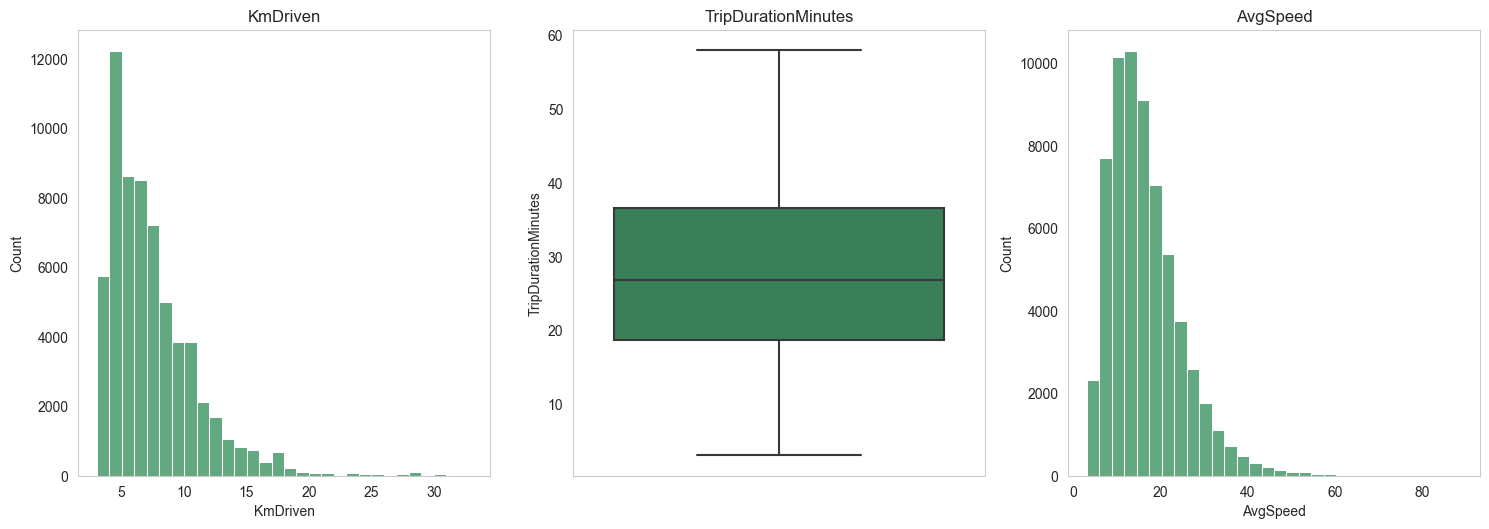

In [ ]:
columns = ['KmDriven', 'TripDurationMinutes', 'AvgSpeed']

# Set the figure size
plt.figure(figsize=(15, 10))

# Create subplots for histograms
for i, column in enumerate(columns):
    plt.subplot(2, 3, i+1)
    if column == 'TripDurationMinutes':
        sns.boxplot(data=gm_processing, y=column, color='seagreen')
    else:
        sns.histplot(data=gm_processing, x=column, bins=30,color='seagreen')
    # sns.boxplot(data=gm_processing[(gm_processing['KmDriven']>=3)&(gm_processing['AvgSpeed']<100)&(gm_processing['AvgSpeed']>5)], y=column, color='seagreen')
    # sns.color_palette('rocket_r')
    sns.set_style('whitegrid')
    plt.grid(False)
    plt.title(column)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
gm_processing.groupby('AgeBracket')['UserID'].unique().apply(len).reset_index().rename(columns={'UserID':'Number of users'})

,AgeBracket,Number of users
0,18-29,3339
1,30-39,1754
2,40-49,1434
3,50-59,816
4,60-90,223


In [ ]:
# # Initialize ShareNow and GreenMobility datasets
# gm_original = pd.read_csv('../data/raw/GM_preparedData.csv')
# # sn_original = pd.read_excel('../data/raw/DriveNow/DTU - data til case_LTMZones1.xlsx')

# #   ----------------------------------------------------------------------------
# #   GREENMOBILITY PART
# #   ----------------------------------------------------------------------------

# # Rename GreenMobility columns
# dict_gm_renamecols = {'id':'TripID',
#                         'vehicleId':'CarID',
#                         'id2':'UserID',
#                         'startPositionLat':'LatitudeStart',
#                         'startPositionLng':'LongitudeStart',
#                         'endPositionLat':'LatitudeEnd',
#                         'endPositionLng':'LongitudeEnd',
#                         'tripStart':'StartTime',
#                         'tripEnd':'EndTime',
#                         'birthday':'Age',
#                         'key':'Gender',
#                         'DriveLength':'KmDriven'
#                       }

# # List the columns to be kept for GreenMobility
# gmkeepcols_list = ['TripID','CarID',
#                    'UserID','LatitudeStart',
#                    'LongitudeStart','LatitudeEnd',
#                    'LongitudeEnd','StartTime',
#                    'EndTime','Age','Gender','KmDriven',
#                    'FromZoneID','ToZoneID']

# gm_test = gm_original.rename(columns=dict_gm_renamecols)
# gm_test = gm_test[gmkeepcols_list]

# # Convert StartTime and EndTime to Datetime
# gm_test['StartTime'] = pd.to_datetime(gm_test['StartTime'], errors='coerce', format='%d%b%y:%H:%M:%S')
# gm_test['EndTime'] = pd.to_datetime(gm_test['EndTime'], errors='coerce' , format='%d%b%y:%H:%M:%S')

# gm_test['TripDurationHours'] = (gm_test['EndTime'] - gm_test['StartTime']).dt.total_seconds()/3600
# gm_test['TripDurationMinutes'] = gm_test['TripDurationHours']*60  #   trip duration in min
# gm_test['AvgSpeed'] = gm_test['KmDriven']/gm_test['TripDurationHours'] #   avg speed
# gm_test['Month'] = gm_test['StartTime'].dt.strftime("%B").astype('category')  #   month
# gm_test['Weekday'] = gm_test['StartTime'].dt.day_name().astype('category')    #   day of the week
# gm_test['StartHour'] = gm_test['StartTime'].dt.hour.astype('category')    #   hour of the day
# gm_test['Date'] = gm_test['StartTime'].dt.date  #   date
# gm_test['AgeBracket'] = gm_test['Age'].apply(get_bracket)   #   age bracket

# gm_test.groupby('AgeBracket')['UserID'].unique().apply(len).reset_index().rename(columns={'UserID':'Number of users'})

In [ ]:
n_steps = 5  # Define the number of steps you want in your color scale
custom_green_scale = generate_custom_colorscale(n_steps, 'Greens' ,dark_start=True)

agg_df = gm_processing.groupby('AgeBracket')['KmDriven'].agg(['mean','count']).reset_index()
fig = px.bar(agg_df, x='AgeBracket', y='count', color='mean',
             color_continuous_scale=custom_green_scale,
             labels={'mean': 'Km', 'count': 'Number of trips', 'AgeBracket':'Age group'})

fig.update_layout(width=500,height=600, template=None, font=dict(family='Aptos',size=18))
fig.update_traces()
# fig.update_yaxes(showgrid=False)
fig.update_xaxes(showgrid=False)
fig.show()


In [ ]:
spped = gm_processing.groupby('AgeBracket')['AvgSpeed'].agg(['mean','count']).reset_index()
fig = px.bar(spped, x='AgeBracket', y='count', color='mean',
             color_continuous_scale=custom_green_scale,
             labels={'mean': 'Km/h', 'count': 'Number of trips', 'AgeBracket':'Age group'})

fig.update_layout(width=500,height=600, template=None, font=dict(family='Aptos',size=18))
fig.update_traces()
# fig.update_yaxes(showgrid=False)
fig.update_xaxes(showgrid=False)
fig.show()

In [ ]:
custom_green_scale = generate_custom_colorscale(7, 'Greens', dark_start=True)

agg_trips_km = gm_processing\
    .groupby('Date')[['TripID','KmDriven']].agg({'TripID':'count','KmDriven':'sum'}).reset_index()
agg_trips_km['Weekday'] = pd.to_datetime(agg_trips_km['Date']).dt.day_name()
daily_trip_km = agg_trips_km.groupby('Weekday').agg({'TripID':'mean','KmDriven':'mean'}).reset_index()
daily_trip_km['KmDriven'] = np.round(daily_trip_km['KmDriven']/daily_trip_km['TripID'],decimals=2)
daily_trip_km['TripID'] = np.round(daily_trip_km['TripID'],decimals=0).astype(int)
daily_trip_km.rename(columns={'TripID':'AvgDemand','KmDriven':'AvgDistance'},inplace=True)

orderlist = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = px.bar(daily_trip_km, x='Weekday', y='AvgDemand',category_orders={'Weekday':orderlist},color='AvgDistance',
             color_continuous_scale=custom_green_scale,
             labels={'AvgDistance': 'Km', 'AvgDemand': 'Number of trips'})

fig.update_layout(width=700,height=600, template=None, font=dict(family='Aptos',size=20))
fig.update_traces()
fig.update_yaxes(showgrid=False)
fig.update_xaxes(
    ticktext=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    tickvals=[0, 1, 2, 3, 4, 5, 6], showgrid=False, title=None
)

fig.show()

In [ ]:
gm_processing.groupby(['Date','StartHour']).agg({'TripID':'count'}).reset_index()

,Date,StartHour,TripID
0,2017-07-01,0.0,16
1,2017-07-01,1.0,5
2,2017-07-01,2.0,10
3,2017-07-01,3.0,4
4,2017-07-01,4.0,10
...,...,...,...
2203,2017-09-30,19.0,57
2204,2017-09-30,20.0,35
2205,2017-09-30,21.0,32
2206,2017-09-30,22.0,21


In [ ]:
# sn_processing['Date'] = sn_processing['StartTime'].dt.date
days = gm_processing.groupby(['Date','StartHour']).agg({'TripID':'count'}).reset_index()
dfplot = days.groupby('StartHour').agg({'TripID':'mean'},).reset_index().rename(columns={'TripID':'AvgDemand'})

custom_green_scale = generate_custom_colorscale(24,'Greens', dark_start=True)

r = dfplot['AvgDemand'].tolist()
theta = np.arange(0,360,15)
width = [15]*24

ticktexts = [str(i)+":00" if i % 6 == 0 else '' for i in np.arange(24)]

fig = go.Figure(go.Barpolar(
    r=r,
    theta=[i-7.5 for i in theta],
    width=width,
    marker_color=dfplot['AvgDemand'],
    marker_colorscale=custom_green_scale,
    marker_line_color="white",
    marker_line_width=2,
    opacity=0.9
))

fig.update_layout(
    template=None,
    polar=dict(
        hole=0.4,
        bgcolor='rgb(223, 223,223)',
        radialaxis=dict(
            showticklabels=False,
            ticks='',
            linewidth=2,
            linecolor='white',
            showgrid=False,
        ),
        angularaxis=dict(
            tickvals=[i for i in theta],
            ticktext=ticktexts,
            showline=True,
            direction='clockwise',
            period=24,
            linecolor='white',
            gridcolor='white',
            showticklabels=True,
            ticks=''
        )
    )
)

fig.show()

In [ ]:
gm_processing['UserID'] = gm_processing['UserID'].astype(int)
gm_processing_groupusers = gm_processing.groupby('UserID')\
    .agg({'TripID':'count','TripDurationMinutes':'mean','KmDriven':'mean'})\
    .reset_index().rename(columns={'TripID':'Number of trips','TripDurationMinutes':'Time (min)','KmDriven':'Trip (km)'})\
    .sort_values('Number of trips',ascending=False)

In [ ]:
gm_processing_groupusers.tail(15).style.format("{:.2f}")

,UserID,Number of trips,Time (min),Trip (km)
2449,6995.00,1.00,20.70,4.00
5923,14591.00,1.00,25.32,7.00
2451,7005.00,1.00,22.50,4.00
5920,14588.00,1.00,44.42,8.00
2461,7028.00,1.00,27.58,7.00
2465,7037.00,1.00,16.73,3.00
2467,7042.00,1.00,26.90,14.00
5914,14578.00,1.00,36.37,16.00
5913,14576.00,1.00,35.78,6.00
2472,7051.00,1.00,37.93,18.00


### 1.3 Data cleaning and processing: Donkey Republic

In [ ]:
dr_processing['TripDurationHours'] = (dr_processing['EndTime'] - dr_processing['StartTime']).dt.total_seconds()/3600
dr_processing['TripDurationMinutes'] = dr_processing['TripDurationHours']*60  #   trip duration in min
dr_processing.describe().T.style.format("{:.2f}")

,count,mean,min,25%,50%,75%,max,std
StartTime,279860.00,.2f,.2f,.2f,.2f,.2f,.2f,nan
EndTime,279408.00,.2f,.2f,.2f,.2f,.2f,.2f,nan
pickup_hub_id,279860.00,2968.64,49.00,2178.00,2413.00,3543.00,7521.00,1474.51
dropoff_hub_id,261293.00,2994.72,49.00,2180.00,2431.00,3730.00,7521.00,1483.24
UserID,279860.00,225811.07,1.00,162493.00,232322.00,293800.00,357173.00,79155.08
LatitudeStart,276689.00,55.68,50.85,55.67,55.68,55.69,55.79,0.02
LongitudeStart,276689.00,12.57,4.40,12.55,12.57,12.58,12.65,0.03
LatitudeEnd,258313.00,55.68,50.85,55.67,55.68,55.69,55.79,0.02
LongitudeEnd,258313.00,12.57,4.40,12.55,12.57,12.58,12.65,0.03
HaversineDistance,110444.00,4.14,0.00,1.47,3.30,5.94,6310.48,19.28


In [ ]:
custom_orange_scale = generate_custom_colorscale(7, 'Oranges', dark_start=True)

agg_trips_km = dr_processing[dr_processing['TripDurationMinutes']<720]\
    .groupby('Date')[['StartTime','HaversineDistance']].agg({'StartTime':'count','HaversineDistance':'sum'}).reset_index()
agg_trips_km['Weekday'] = pd.to_datetime(agg_trips_km['Date']).dt.day_name()
daily_trip_km = agg_trips_km.groupby('Weekday').agg({'StartTime':'mean','HaversineDistance':'mean'}).reset_index()
daily_trip_km['HaversineDistance'] = np.round(daily_trip_km['HaversineDistance']/daily_trip_km['StartTime'],decimals=2)
daily_trip_km['StartTime'] = np.round(daily_trip_km['StartTime'],decimals=0).astype(int)
daily_trip_km.rename(columns={'StartTime':'AvgDemand','HaversineDistance':'AvgDistance'},inplace=True)

orderlist = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = px.bar(daily_trip_km, x='Weekday', y='AvgDemand',category_orders={'Weekday':orderlist},
             color='AvgDistance',
             color_continuous_scale=custom_orange_scale,
             labels={'AvgDemand': 'Number of trips', 'AvgDistance': 'Km'})

fig.update_layout(width=700,height=600, template=None, font=dict(family='Aptos',size=20))
fig.update_traces()
fig.update_yaxes(showgrid=False)
fig.update_xaxes(
    ticktext=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    tickvals=[0, 1, 2, 3, 4, 5, 6], showgrid=False, title=None
)

fig.show()

In [ ]:
daily_trip_km

,Weekday,AvgDemand,AvgDistance
0,Friday,600,1.38
1,Monday,499,1.59
2,Saturday,650,1.53
3,Sunday,589,1.67
4,Thursday,508,1.58
5,Tuesday,465,1.40
6,Wednesday,491,1.52


In [ ]:
days = dr_processing.groupby(['Date','StartHour']).agg({'StartTime':'count'}).reset_index()
dfplot = days.groupby('StartHour').agg({'StartTime':'mean'},).reset_index().rename(columns={'StartTime':'AvgDemand'})

custom_green_scale = generate_custom_colorscale(24,'Oranges', dark_start=True)

r = dfplot['AvgDemand'].tolist()
theta = np.arange(0,360,15)
width = [15]*24

ticktexts = [str(i)+":00" if i % 6 == 0 else '' for i in np.arange(24)]

fig = go.Figure(go.Barpolar(
    r=r,
    theta=[i-7.5 for i in theta],
    width=width,
    marker_color=dfplot['AvgDemand'],
    marker_colorscale=custom_green_scale,
    marker_line_color="white",
    marker_line_width=2,
    opacity=0.9
))

fig.update_layout(
    template=None,
    polar=dict(
        hole=0.4,
        bgcolor='rgb(223, 223,223)',
        radialaxis=dict(
            showticklabels=False,
            ticks='',
            linewidth=2,
            linecolor='white',
            showgrid=False,
        ),
        angularaxis=dict(
            tickvals=[i for i in theta],
            ticktext=ticktexts,
            showline=True,
            direction='clockwise',
            period=24,
            linecolor='white',
            gridcolor='white',
            showticklabels=True,
            ticks=''
        )
    )
)

fig.show()

In [ ]:
dr_processing[dr_processing['dropoff_hub_id'].isnull()].groupby('StartHubName').agg({'StartTime':'count'}).reset_index().rename(columns={'StartTime':'Number of trips'}).sort_values(by='Number of trips',ascending=False).head(15)

,StartHubName,Number of trips
594,Nørreport St. (Nørre Voldgade),454
593,Nørreport St. (Depot),192
388,Israels Plads,158
857,Vandkunsten,147
138,Central Station,145
661,Reventlowsgade,141
817,Tourist Information Office,125
540,Mindeankeret,124
816,Torvehallerne,122
254,Founders House,120


In [ ]:
dr_processing = dr_processing[~dr_processing['dropoff_hub_id'].isnull()]
dr_processing = dr_processing[dr_processing['TripDurationMinutes']>0]
dr_processing[['TripDurationMinutes','TripDurationHours']].describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
TripDurationMinutes,261179.00,566.33,1546.58,0.27,25.79,221.06,591.80,126554.99
TripDurationHours,261179.00,9.44,25.78,0.00,0.43,3.68,9.86,2109.25


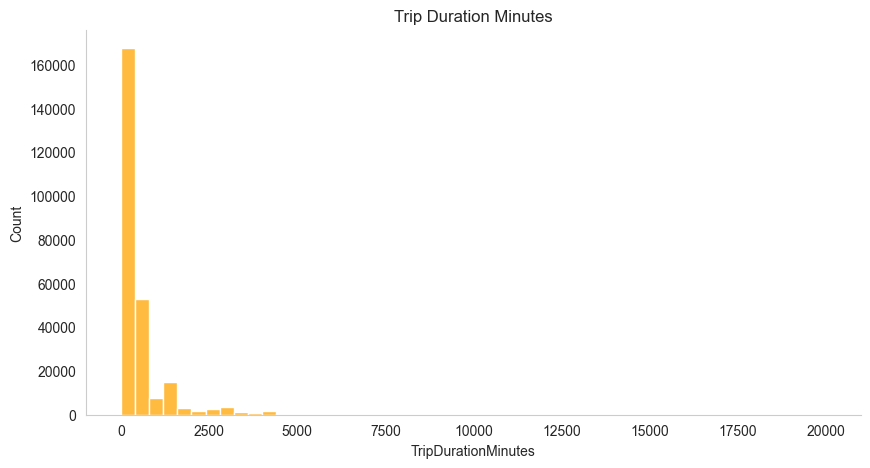

In [ ]:
# plot gm_processing['TripDurationMinutes'] histogram using seaborn
plt.figure(figsize=(10, 5))
sns.histplot(data=dr_processing[dr_processing['TripDurationMinutes']<20000], x='TripDurationMinutes', bins=50, color='orange')
sns.set_style('whitegrid')
sns.despine()
plt.grid(False)
plt.title('Trip Duration Minutes')
plt.show()

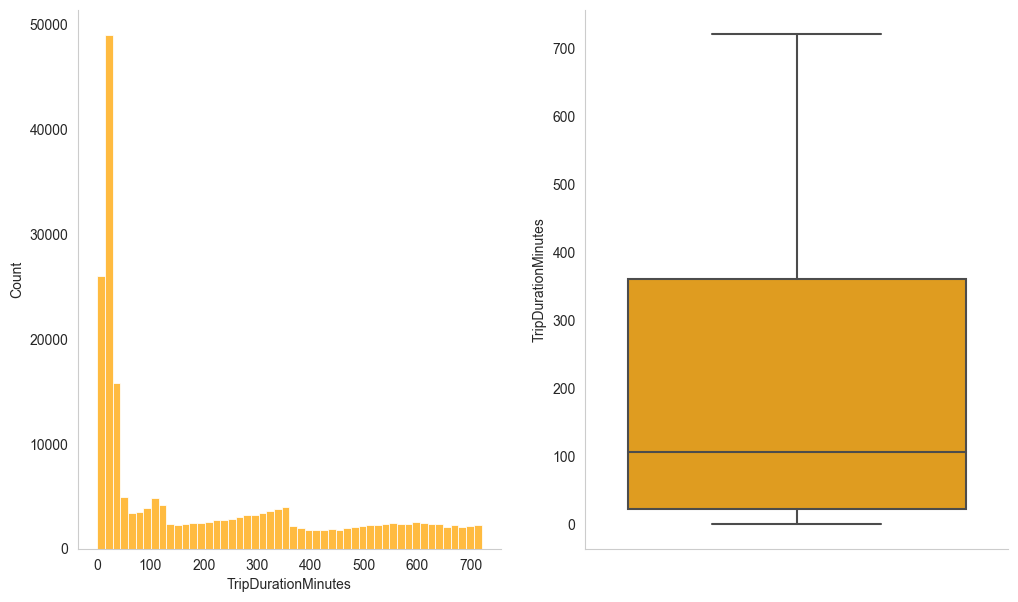

In [ ]:
# (dr_processing[dr_processing['TripDurationMinutes']<720].shape[0]/dr_processing.shape[0])*100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
sns.histplot(data=dr_processing[dr_processing['TripDurationMinutes']<720], x='TripDurationMinutes', bins=50, color='orange', ax=ax1)
sns.boxplot(data=dr_processing[dr_processing['TripDurationMinutes']<720], y='TripDurationMinutes',color='orange', ax=ax2)
ax1.grid(False)
ax2.grid(False)
sns.set_style('whitegrid')
sns.despine()
plt.grid(False)
# plt.title('Trip Duration Minutes')
plt.show()

In [ ]:
rentals['user_id'].value_counts()

user_id
140961    636
202440    423
138203    383
105294    382
112336    339
         ... 
203861      1
204421      1
203786      1
204351      1
357046      1
Name: count, Length: 81419, dtype: int64

In [ ]:
dr_processing['UserID'] = dr_processing['UserID'].astype(int)
dr_processing_groupusers = dr_processing.groupby('UserID')\
    .agg({'StartTime':'count','TripDurationMinutes':'mean'})\
    .reset_index().rename(columns={'StartTime':'Trips','TripDurationMinutes':'Time (min)'})\
    .sort_values('Trips',ascending=False)

# dr_processing_groupusers['Trips'] = dr_processing_groupusers['Trips'].astype(int)
# dr_processing_groupusers['Time (min)'] = dr_processing_groupusers['Time (min)'].map('{:.2f}'.format)

In [ ]:
dr_processing_groupusers.head(15)

,UserID,Trips,Time (min)
9838,140961,634,526.32
28114,202440,415,602.14
8823,138203,381,548.44
2002,105294,380,746.13
27700,200997,332,341.38
8810,138159,318,456.52
12441,149801,316,626.67
33067,218607,313,395.33
2979,116766,310,559.28
26347,195931,310,187.57


In [ ]:
dr_processing_groupusers.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
UserID,76680.00,232820.32,75046.76,1.00,171587.00,236647.00,297342.00,357161.00
Trips,76680.00,3.41,12.36,1.00,1.00,1.00,2.00,634.00
Time (min),76680.00,895.58,1880.84,0.76,112.32,356.54,1180.81,122081.77


In [ ]:
display(HTML('<p style="font-size:20px; font-family:Consolas;">Average car usage ShareNow</p>'))
sn_processing.groupby(['CarID','Date']).agg({'TripID':'count','KmDriven':'sum'}).reset_index().agg({'TripID':'mean','KmDriven':'mean'}).to_frame().rename(columns={0:'Average'}).style.format("{:.2f}")

,Average
TripID,4.30
KmDriven,34.95


In [ ]:
dr_processing.columns

NameError: name 'dr_processing' is not defined

In [ ]:
day_hour_sn = sn_processing.groupby(['Weekday','StartHour','Date']).agg({'CarID':'count'}).reset_index()
day_hour_gm = gm_processing.groupby(['Weekday','StartHour','Date']).agg({'CarID':'count'}).reset_index()
day_hour_dr = dr_processing.groupby(['Weekday','StartHour','Date']).agg({'pickup_hub_id':'count'}).reset_index()

In [ ]:
test_sn = day_hour_sn.groupby(['Weekday','StartHour']).agg({'TripID':'mean'}).reset_index()
test_gm = day_hour_gm.groupby(['Weekday','StartHour']).agg({'TripID':'mean'}).reset_index()
test_dr = day_hour_dr.groupby(['Weekday','StartHour']).agg({'Date':'mean'}).reset_index()

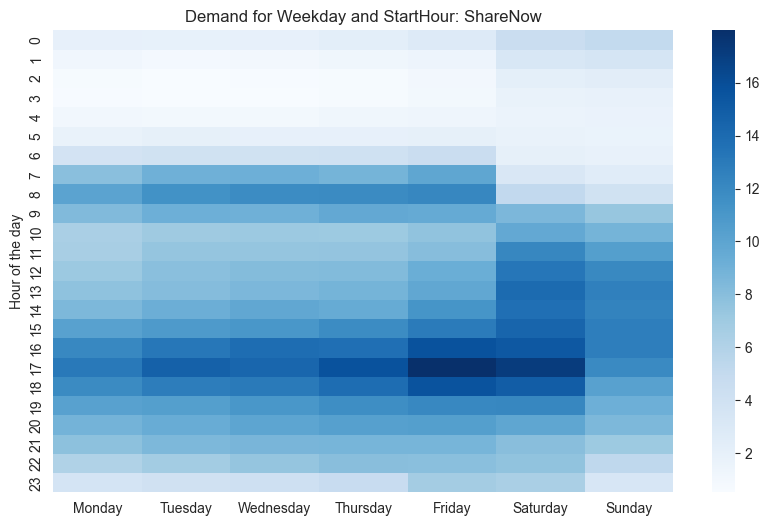

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Assuming day_hour is a DataFrame you have defined earlier

# Reshape the data into a matrix
matrix = test_sn.pivot(index='StartHour', columns='Weekday', values='TripID')

# Order list for the weekdays
orderlist = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex the matrix according to the orderlist
reordered_matrix = matrix.reindex(columns=orderlist)

# Create the heatmap with the reordered matrix
plt.figure(figsize=(10, 6))
sns.heatmap(reordered_matrix, cmap='Blues', annot=False, fmt='d')
plt.title('Demand for Weekday and StartHour: ShareNow')
plt.xlabel(None)
plt.ylabel('Hour of the day')
plt.show()


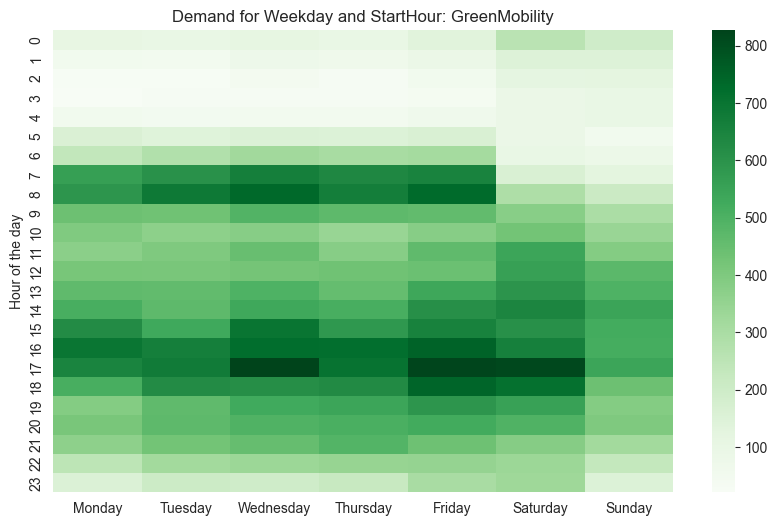

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Assuming day_hour is a DataFrame you have defined earlier

# Reshape the data into a matrix
test_gm['StartHour'] = test_gm['StartHour'].astype(int)
matrix = test_gm.pivot(index='StartHour', columns='Weekday', values='TripID')

# Order list for the weekdays
orderlist = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex the matrix according to the orderlist
reordered_matrix = matrix.reindex(columns=orderlist)

# Create the heatmap with the reordered matrix
plt.figure(figsize=(10, 6))
sns.heatmap(reordered_matrix, cmap='Greens', annot=False, fmt='d')
plt.title('Demand for Weekday and StartHour: GreenMobility')
plt.xlabel(None)
plt.ylabel('Hour of the day')
plt.show()


/opt/anaconda3/envs/master_thesis/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning:

All-NaN slice encountered

/opt/anaconda3/envs/master_thesis/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning:

All-NaN slice encountered



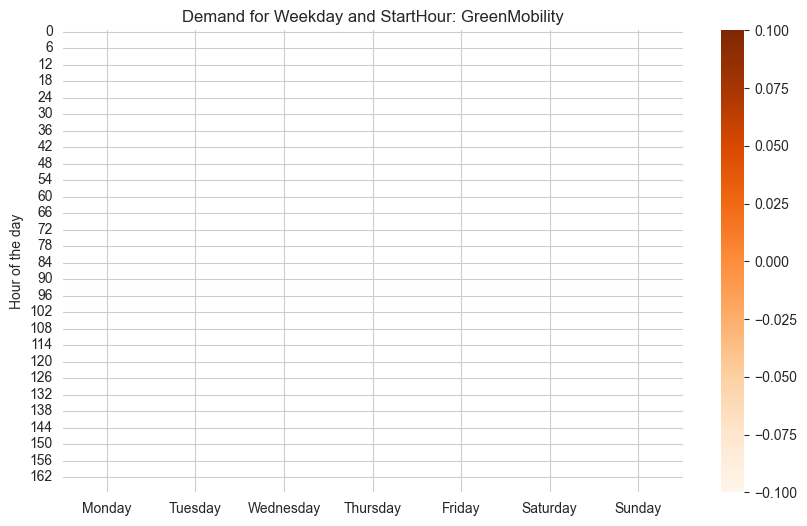

In [ ]:
# Reshape the data into a matrix
day_hour_dr['StartHour'] = day_hour_dr['StartHour'].astype(int)
matrix = day_hour_dr.pivot(index='StartHour', columns='Weekday', values='Date')

# Order list for the weekdays
orderlist = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex the matrix according to the orderlist
reordered_matrix = test_dr.reindex(columns=orderlist)

# Create the heatmap with the reordered matrix
plt.figure(figsize=(10, 6))
sns.heatmap(reordered_matrix, cmap='Oranges', annot=False, fmt='d')
plt.title('Demand for Weekday and StartHour: GreenMobility')
plt.xlabel(None)
plt.ylabel('Hour of the day')
plt.show()


In [ ]:
sn_processing.groupby('CarID').agg({'TripID':'count','KmDriven':'mean'}).reset_index()

,CarID,TripID,KmDriven
0,WBY1Z21000V307738,1158,8.304836
1,WBY1Z21000V307741,1055,8.196209
2,WBY1Z21000V307755,803,7.948941
3,WBY1Z21000V307772,993,7.789527
4,WBY1Z21000V307805,1019,7.760550
...,...,...,...
341,WBY1Z6107HV939137,1106,9.199819
342,WBY1Z6107HV939140,1087,9.454462
343,WBY1Z6108HV938983,1116,8.849462
344,WBY1Z6109HV939138,1167,8.588689


In [ ]:
display(HTML('<p style="font-size:20px; font-family:Consolas;">Average car usage GreenMobility</p>'))
gm_processing.groupby(['CarID','Date']).agg({'TripID':'count','KmDriven':'sum'}).reset_index().agg({'TripID':'mean','KmDriven':'mean'}).to_frame().rename(columns={0:'Average'}).style.format("{:.2f}")

,Average
TripID,2.60
KmDriven,18.17


In [ ]:
alltrips = pd.read_csv('../data/processed/alltrips.csv', low_memory=False)

In [ ]:
alltrips.columns

Index(['vehicleId', 'PersonID', 'LatitudeStart', 'LongitudeStart',
       'LatitudeEnd', 'LongitudeEnd', 'StartTime', 'EndTime', 'Age', 'Gender',
       'KmDriven', 'FromZoneID', 'ToZoneID', 'TripDurationHours',
       'TripDurationMinutes', 'AvgSpeed', 'Month', 'Weekday', 'StartHour',
       'HaversineDistance', 'StartTimeUpdated', 'TotalDurationMin',
       'TripDistanceKm', 'TotalWalkingTimeMin', 'TotalTransitTimeMin',
       'Changes', 'PickupStationProximity', 'DropoffStationProximity',
       'CarDurationMin', 'CarDistanceKm', 'source'],
      dtype='object')

/opt/anaconda3/envs/master_thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/envs/master_thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/envs/master_thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/envs/master_thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/envs/master_thesi

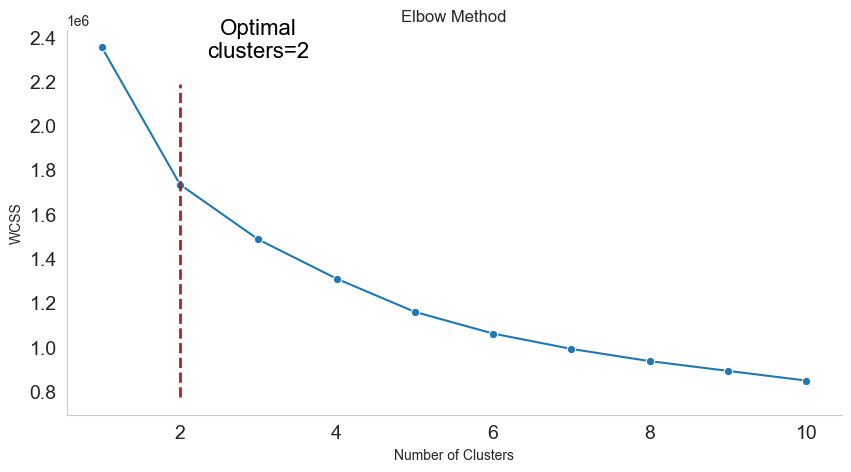

In [ ]:
alltrips['RowID'] = alltrips.index
features = alltrips[['RowID','KmDriven','Age','TripDurationMinutes','HaversineDistance','AvgSpeed']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)


plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, 11), y=wcss, marker='o', linestyle='-')
# sns.scatterplot(x=range(1, 11), y=wcss, palette='coolwarm', s=100)
sns.despine()
y_min, y_max = plt.ylim()
y_lim = (y_min, y_max*0.9)
# set xticks font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Draw a vertical line at x=3 with custom y limits
plt.vlines(x=2, ymin=y_lim[0], ymax=y_lim[1], colors='firebrick', linestyles='--', linewidth=2)

# Optionally, you can add annotations to mark the optimal number of clusters
plt.text(3, y_max * 0.95, 'Optimal\nclusters=2', color='black', horizontalalignment='center', fontsize=16)
plt.title('Elbow Method')
plt.ylabel('WCSS')
plt.xlabel('Number of Clusters')
plt.grid(False)
plt.show()

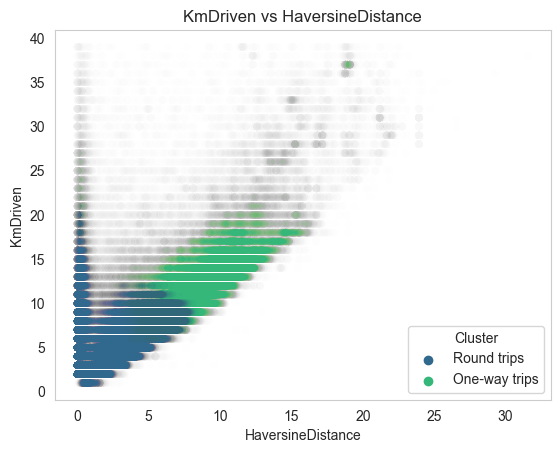

In [ ]:
# Plotting code
sns.scatterplot(data=alltrips, x='HaversineDistance', y='KmDriven', hue='Cluster',palette='viridis', alpha=0.005)

# Rename the legend
new_labels = ['Round trips', 'One-way trips']
for t,l in zip(plt.gca().get_legend().texts, new_labels): 
    t.set_text(l)

# Display the plot
sns.set_style('whitegrid')
plt.grid(False)
plt.title('KmDriven vs HaversineDistance')
plt.show()

In [11]:
sn_processing.groupby(['Date','Weekday'])['TripID'].count().reset_index()
    # .groupby(['Weekday','StartHour'])['TripID'].mean().reset_index()


,Date,Weekday,TripID
0,2017-07-31,Friday,0
1,2017-07-31,Monday,15
2,2017-07-31,Saturday,0
3,2017-07-31,Sunday,0
4,2017-07-31,Thursday,0
...,...,...,...
1969,2018-05-08,Saturday,0
1970,2018-05-08,Sunday,0
1971,2018-05-08,Thursday,0
1972,2018-05-08,Tuesday,1404
